In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [10]:
writer = SummaryWriter('runs/cifar10_vgg16')

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


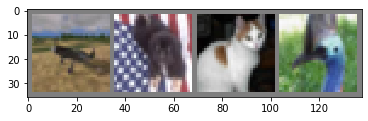

plane   dog   cat  bird


In [12]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
img_grid = torchvision.utils.make_grid(images)
imshow(img_grid)
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
device = torch.device("cpu")

print(device)
net = torchvision.models.vgg16()
net.to(device)

writer.add_graph(net,images.to(device))
writer.close()

cpu


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            
            writer.add_scalar('training loss', running_loss / 2000,
                              epoch * len(trainloader) + i)
            
            running_loss = 0.0

print('Finished Training')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001F0AAF90B88>
Traceback (most recent call last):
  File "c:\users\yemq3\appdata\local\programs\python\python37\lib\site-packages\torch\utils\data\dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "c:\users\yemq3\appdata\local\programs\python\python37\lib\site-packages\torch\utils\data\dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "c:\users\yemq3\appdata\local\programs\python\python37\lib\multiprocessing\process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "c:\users\yemq3\appdata\local\programs\python\python37\lib\multiprocessing\popen_spawn_win32.py", line 104, in wait
KeyboardInterrupt: 
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\yemq3\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-f61938bfb852>", line 15, in <module>
    loss.backward()
  File "c:\users\yemq3\appdata\local\programs\python\python37\lib\site-packages\torch\tensor.py", line 118, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "c:\users\yemq3\appdata\local\programs\python\python37\lib\site-packages\torch\autograd\__init__.py", line 93, in backward
    allow_unreachable=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\yemq3\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeEr

KeyboardInterrupt: 

In [ ]:
net.feature_map_conv1.shape

In [ ]:
# feature_map_conv1_grid = torchvision.utils.make_grid(net.feature_map_conv1[0].unsqueeze(dim=1),normalize=True)
# writer.add_image('feature_map_conv1', feature_map_conv1_grid)
# feature_map_conv2_grid = torchvision.utils.make_grid(net.feature_map_conv2[0].unsqueeze(dim=1),normalize=True)
# writer.add_image('feature_map_conv2', feature_map_conv2_grid)

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
def test(net, weight_path, testloader):
    net.load_state_dict(torch.load(weight_path))

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
net = Net()
test(net, PATH, testloader)